In [5]:
#adapted fron https://www.kaggle.com/tunguz/xgboost-starter
#https://www.kaggle.com/anokas/talkingdata-adtracking-eda
import pandas as pd
import time
import numpy as np
import os 
import gc 
from matplotlib import pyplot
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline
import datetime
from sklearn.cross_validation import train_test_split
import xgboost as xgb
 
path = '../capstone/' 

In [6]:
#load 2 million dataset
train = pd.read_csv(path+"train.csv", nrows=2000000) #2 mill

In [7]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


In [8]:
train.drop('click_time', axis=1, inplace=True)

In [9]:
#target variable
y = train['is_attributed']
train.drop(['is_attributed', 'attributed_time'], axis=1, inplace=True)

In [10]:
start_time = time.time()
sub = pd.DataFrame()
print('[{}] Start XGBoost Training'.format(time.time() - start_time))

[0.0009748935699462891] Start XGBoost Training


XGBoost:-

Model PROS:
    
Not affected by multicollinearity
Low variance, so not susceptible to overfitting like decision trees
Works well with large amount of features
Provides estimates of feature importance

Model CONS:

For categorical variables with different number of levels, random forests are biased in favor of those attributes with more levels
Relatively difficult to interpret

In [29]:
params = {'eta': 0.1, 
          'max_depth': 5, 
          'subsample': 0.9, 
          'colsample_bytree': 0.7, 
          'colsample_bylevel':0.7,
          'min_child_weight':100,
          'alpha':4,
          'objective': 'binary:logistic', 
          'eval_metric': 'auc', 
          'random_state': 23, 
          'scale_pos_weight': 120,
          'silent': True}
          
x1, x2, y1, y2 = train_test_split(train, y, test_size=0.1, random_state=99)
#creating matrix
watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')] #x1=training, y1=target
model = xgb.train(params, xgb.DMatrix(x1, y1), 100, watchlist, maximize=True, verbose_eval=10)

print('[{}] Finish XGBoost Training'.format(time.time() - start_time))
sub['is_attributed'] = model.predict(xgb.DMatrix(x2), ntree_limit=model.best_ntree_limit)
sub.to_csv('xgb_sub_dub_2mill.csv',index=False)

[0]	train-auc:0.90349	valid-auc:0.879048
[10]	train-auc:0.938977	valid-auc:0.939491
[20]	train-auc:0.941291	valid-auc:0.940179
[30]	train-auc:0.943421	valid-auc:0.942232
[40]	train-auc:0.949386	valid-auc:0.942464
[50]	train-auc:0.954674	valid-auc:0.941487
[60]	train-auc:0.958978	valid-auc:0.940165
[70]	train-auc:0.961994	valid-auc:0.941022
[80]	train-auc:0.964812	valid-auc:0.942077
[90]	train-auc:0.967064	valid-auc:0.942405
[99]	train-auc:0.968163	valid-auc:0.942163
[102.00958800315857] Finish XGBoost Training


In [30]:
#confusion
from sklearn.metrics import confusion_matrix
sub['is_attributed'] = model.predict(xgb.DMatrix(x2), ntree_limit=model.best_ntree_limit)

In [31]:
#grouping file created as the result is in float
for i in range(len(sub['is_attributed'])):
    if sub['is_attributed'][i]>0.5:
           sub['is_attributed'][i] = 1
    else:
          sub['is_attributed'][i]=0

In [32]:
#Confusion matrix for XGboost
confusion_matrix(y2, sub)

array([[99139,   700],
       [   46,   115]])

The confusion matrix from XGBoost shows 
Accuracy: Overall, how often is the classifier correct? 99.254%
Misclassification Rate: Overall, how often is it wrong? 0.746%
True Positive Rate: When it's actually yes, how often does it predict yes? 0.115%
False Positive Rate: When it's actually no, how often does it predict yes? 0.70%
True Negative Rate: When it's actually no, how often does it predict no? 99.29%%

In [33]:
#roc curve
from sklearn.metrics import roc_curve
roc_curve(y2, sub, pos_label=1, sample_weight=None, drop_intermediate=True)

(array([0.        , 0.00701129, 1.        ]),
 array([0.        , 0.71428571, 1.        ]),
 array([2., 1., 0.], dtype=float32))

In [34]:
from matplotlib import pyplot

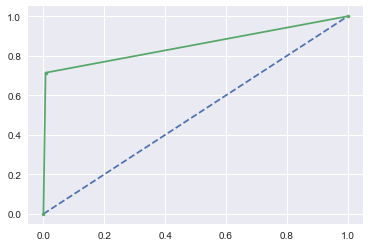

In [35]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y2, sub)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

Random Forest:-

Model PROS:
    
Not affected by multicollinearity
Low variance, so not susceptible to overfitting like decision trees
Works well with large amount of features
Provides estimates of feature importance

Model CONS:

For categorical variables with different number of levels, random forests are biased in favor of those attributes with more levels
Relatively difficult to interpret

In [36]:
x1, x2, y1, y2 = train_test_split(train, y, test_size=0.1, random_state=99)
#Calculating Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(x1,y1)

y_pred=clf.predict(x2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y2, y_pred))

Accuracy: 0.99808
